# Proyección Anual del PML

In [29]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

ruta = 'C:/Cursos/Data Science/Proyecto CENANCE/pml-cancun-forecasting/data/PML_CANCUN_FINAL.csv'

# Cargar Datos
try:
    df = pd.read_csv(ruta, parse_dates=['fecha'])
    print("✅ Archivo cargado correctamente")
    print(f"📊 Dimensiones: {df.shape}")
    
    # Mostrar las primeras filas 
    print(df.tail())

except Exception as e:
    print(f"❌ Error al cargar el archivo: {str(e)}")
    print("\n🔍 Verifica:")
    print(f"1. Que el archivo existe en: {ruta}")
    print("2. Que el nombre del archivo es exactamente 'PML_CANCUN_FINAL.csv'")
    print("3. Que no hay caracteres especiales en la ruta")
    
def parse_mixed_dates(date_str):
    try:
        # Primero intenta con formato AAAA-MM-DD
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except ValueError:
        try:
            # Si falla, intenta con formato DD/MM/AAAA
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        except ValueError:
            # Si ambos fallan, devuelve NaT (Not a Time)
            return pd.NaT

# Aplicar la función a la columna de fechas
df['fecha'] = df['fecha'].apply(parse_mixed_dates)

# Verificar si hay fechas no convertidas
if df['fecha'].isna().any():
    print(f"⚠️ Advertencia: {df['fecha'].isna().sum()} fechas no pudieron convertirse")
    print("Registros problemáticos:")
    print(df[df['fecha'].isna()])
else:
    print("✅ Todas las fechas convertidas exitosamente")

# Combinar con la hora (1-24) para crear timestamp completo
df['fecha_hora'] = df['fecha'] + pd.to_timedelta(df['hora'] - 1, unit='h')

# Eliminar filas con fechas inválidas si es necesario
df = df.dropna(subset=['fecha'])

# Verificar resultados
print("\nEjemplo de fechas convertidas:")
print(df[['fecha', 'hora', 'fecha_hora']].head(3))
print("\nEjemplo del registro problemático convertido:")
print(df[df['fecha_hora'].dt.strftime('%d/%m/%Y') == '15/08/2024'].head())

✅ Archivo cargado correctamente
📊 Dimensiones: (17470, 6)
            fecha  hora    zona  precio  energia  congestion
17465  30/09/2020    20  CANCUN  604.48   523.48         0.0
17466  30/09/2020    21  CANCUN  620.15   531.40         0.0
17467  30/09/2020    22  CANCUN  625.37   532.39         0.0
17468  30/09/2020    23  CANCUN  625.96   521.96         0.0
17469  30/09/2020    24  CANCUN  625.87   519.85         0.0
✅ Todas las fechas convertidas exitosamente

Ejemplo de fechas convertidas:
       fecha  hora          fecha_hora
0 2020-04-01     1 2020-04-01 00:00:00
1 2020-04-01     2 2020-04-01 01:00:00
2 2020-04-01     3 2020-04-01 02:00:00

Ejemplo del registro problemático convertido:
          fecha  hora    zona   precio  energia  congestion  \
6093 2024-08-15     1  CANCUN  5770.44  1082.40     4418.25   
6094 2024-08-15     2  CANCUN   970.89   774.01       -0.12   
6095 2024-08-15     3  CANCUN   634.29   508.03       -0.25   
6096 2024-08-15     4  CANCUN   544.40   440.

# --------------------------
# 1. Escenarios y supuestos a largo plazo

Para la proyección anual del Precio Marginal Local (PML), se consideran los siguientes supuestos:

- Se mantiene el comportamiento estacional observado en los datos históricos.
- No se contemplan eventos extraordinarios como cambios regulatorios, desastres naturales o crisis económicas.
- Se espera una demanda energética relativamente estable, sin incrementos abruptos ni decrecimientos marcados.
- Los modelos se entrenan únicamente con series históricas de precios, sin variables exógenas.
- Las proyecciones a 1, 3 y 5 años se hacen con frecuencias horarias y agregaciones anuales posteriores para facilitar el análisis.

Estos supuestos permiten generar escenarios base útiles para análisis exploratorios y planeación energética.

# --------------------------

✅ Datos cargados y preprocesados exitosamente.

✅ Modelo SARIMAX entrenado con órdenes fijas.

✅ Pronóstico para 1 año generado.

✅ Pronóstico para 3 años generado.

✅ Pronóstico para 5 años generado.


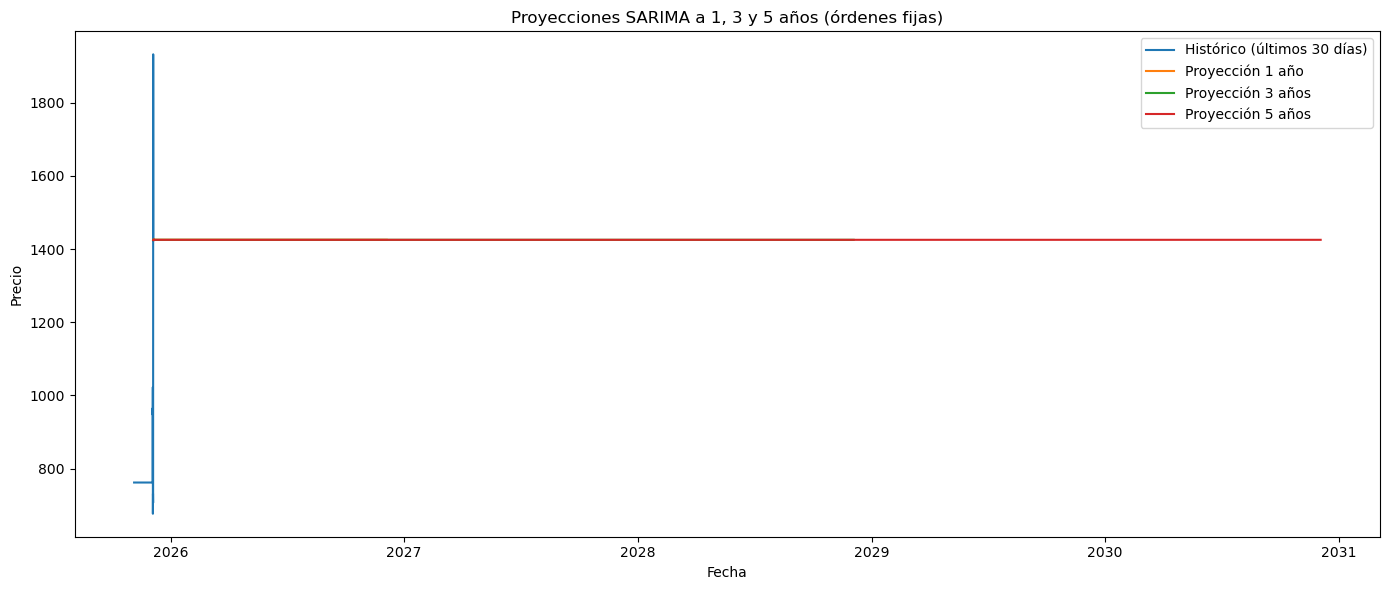

📤 Archivo exportado: proyeccion_sarima_fijo_1_año.csv
📤 Archivo exportado: proyeccion_sarima_fijo_3_años.csv
📤 Archivo exportado: proyeccion_sarima_fijo_5_años.csv

🎉 ¡Proceso de proyección anual con órdenes fijas completado!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

ruta = 'C:/Cursos/Data Science/Proyecto CENANCE/pml-cancun-forecasting/data/PML_CANCUN_FINAL.csv'

# 1. Cargar datos de manera ROBUSTA 
try:
    df = pd.read_csv(ruta)
    df['fecha_hora'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'].astype(str) + ':00', errors='coerce')
    df = df.dropna(subset=['fecha_hora', 'precio'])
    df['precio'] = pd.to_numeric(df['precio'], errors='coerce')
    df = df.dropna(subset=['precio'])
    df = df[['fecha_hora', 'precio']].sort_values(by='fecha_hora').drop_duplicates(subset=['fecha_hora'], keep='first').set_index('fecha_hora')
    df = df.asfreq('H', method='ffill')
    print("✅ Datos cargados y preprocesados exitosamente.")
except Exception as e:
    print(f"❌ Error al cargar y preprocesar los datos: {e}")
    exit()

# 2. Definir órdenes fijos para SARIMA
order = (1, 1, 1)          # Orden no estacional (p, d, q) - ién!
seasonal_order = (1, 0, 1, 24) # Orden estacional (P, D, Q, s) - 's' es la estacionalidad (24 horas)

try:
    # 3. Entrenar el modelo SARIMAX con los órdenes definidos
    modelo_sarima = SARIMAX(df['precio'],
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    resultado = modelo_sarima.fit(disp=False)
    print("\n✅ Modelo SARIMAX entrenado con órdenes fijas.")

    # 4. Generar pronósticos
    horas_pronostico = {
        '1 año': 24 * 365,
        '3 años': 24 * 365 * 3,
        '5 años': 24 * 365 * 5
    }
    predicciones_sarima = {}

    for label, h in horas_pronostico.items():
        pred = resultado.get_forecast(steps=h)
        pred_df = pd.DataFrame({'precio_predicho': pred.predicted_mean})
        pred_df.index = pd.date_range(start=df.index[-1], periods=h, freq='H')
        predicciones_sarima[label] = pred_df.reset_index().rename(columns={'index': 'fecha_hora'})
        print(f"\n✅ Pronóstico para {label} generado.")

    # 5. Visualización(
    plt.figure(figsize=(14, 6))
    plt.plot(df[-24 * 30:], label='Histórico (últimos 30 días)')
    for label, df_pred in predicciones_sarima.items():
        plt.plot(df_pred['fecha_hora'], df_pred['precio_predicho'], label=f'Proyección {label}')
    plt.legend()
    plt.title("Proyecciones SARIMA a 1, 3 y 5 años (órdenes fijas)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.tight_layout()
    plt.show()

    # 6. Exportar a CSV
    for label, df_pred in predicciones_sarima.items():
        archivo = f"proyeccion_sarima_fijo_{label.replace(' ', '_')}.csv"
        df_pred.to_csv(archivo, index=False)
        print(f"📤 Archivo exportado: {archivo}")

    print("\n🎉 ¡Proceso de proyección anual con órdenes fijas completado!")

except Exception as e:
    print(f"\n❌ ERROR CRÍTICO al entrenar o pronosticar con SARIMA (órdenes fijas): {e}")
    print("Revisa los órdenes definidos y asegúrate de que los datos estén correctamente preprocesados.")


# --------------------------
# 2. Visualización
# --------------------------

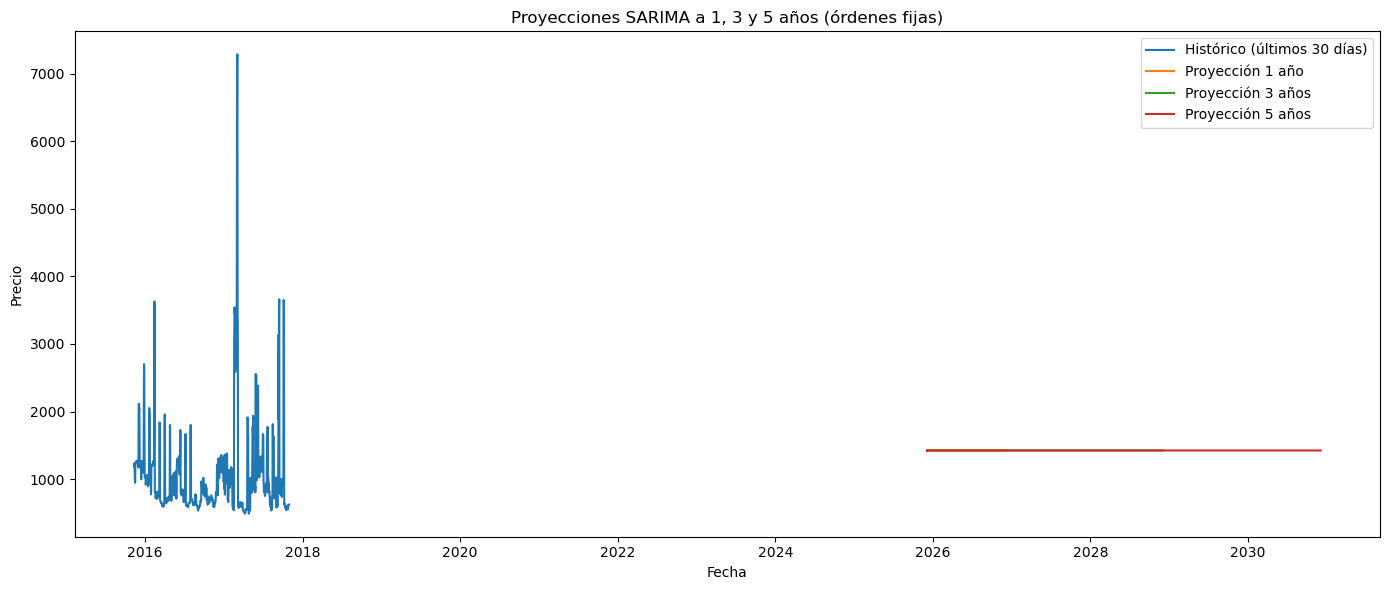

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[-24 * 30:], df['precio'][-24 * 30:], label='Histórico (últimos 30 días)')
for label, df_pred in predicciones_sarima.items():
    plt.plot(df_pred['fecha_hora'], df_pred['precio_predicho'], label=f'Proyección {label}')
plt.legend()
plt.title("Proyecciones SARIMA a 1, 3 y 5 años (órdenes fijas)")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.tight_layout()
plt.show()

# --------------------------
# 3. Métricas de error solo sobre el histórico
# --------------------------

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predicciones_entrenamiento = resultado.fittedvalues
real_entrenamiento = df['precio']

# Asegurarse de que tengan la misma longitud y estén alineados por índice
predicciones_entrenamiento = predicciones_entrenamiento[real_entrenamiento.index]

mae_sarima = mean_absolute_error(real_entrenamiento, predicciones_entrenamiento)
rmse_sarima = np.sqrt(mean_squared_error(real_entrenamiento, predicciones_entrenamiento))
mape_sarima = np.mean(np.abs((real_entrenamiento - predicciones_entrenamiento) / real_entrenamiento)) * 100

print(f"MAE (SARIMA - Ajuste): {mae_sarima:.2f}")
print(f"RMSE (SARIMA - Ajuste): {rmse_sarima:.2f}")
print(f"MAPE (SARIMA - Ajuste): {mape_sarima:.2f}%")

MAE (SARIMA - Ajuste): 1853.87
RMSE (SARIMA - Ajuste): 3207.75
MAPE (SARIMA - Ajuste): nan%


# --------------------------
# 4. Exportar para Power BI
# --------------------------

In [35]:
ruta_exportacion_sarima = 'C:/Cursos/Data Science/Proyecto CENANCE/pml-cancun-forecasting/data/proyeccion_anual_sarima.csv'
pronostico_exportar_sarima = predicciones_sarima['5 años'].rename(columns={'precio_predicho': 'precio_proyectado'})

# Exportar a CSV
pronostico_exportar_sarima.to_csv(ruta_exportacion_sarima, index=False)
print(f"📤 Archivo de proyección anual SARIMA exportado en: {ruta_exportacion_sarima}")

📤 Archivo de proyección anual SARIMA exportado en: C:/Cursos/Data Science/Proyecto CENANCE/pml-cancun-forecasting/data/proyeccion_anual_sarima.csv
